In [1757]:
import numpy as np 
import scipy 
from matplotlib import pyplot as plt 
import pandas as pd
import networkx as nx

This will take in our filtered dataframe and turn it into a graph edgelist
- if two authors worked on the same publication, add an edge between them
- each edge has weight according to how many people cited the paper after five years
- each edge will be time indexed according to the year of publication
- from this multiple graphs will be created indexed by year 

In [1758]:
df = pd.read_csv('data/aps_filtered_data.csv')
df

,Unnamed: 0,Author,Publications,Gender,Date,Year,Num Coauthors,Coauthors,Author Rank
0,0,adam marblestone,10.1103/PhysRevB.79.184301,M,2009-05-13,2009,3,"['Archana Kamal', 'Adam Marblestone', 'Michel ...",1.0
1,1,antony a. wills,10.1103/PhysRevLett.85.3113,M,2000-10-09,2000,7,"['S. E. Canton-Rogan', 'A. A. Wills', 'T. W. G...",1.0
2,2,antony a. wills,10.1103/PhysRevA.57.R1485,M,1998-03-01,1998,9,"['E. Kukk', 'A. Wills', 'N. Berrah', 'B. Lange...",1.0
3,3,antony a. wills,10.1103/PhysRevLett.80.5085,M,1998-06-08,1998,9,"['A. A. Wills', 'T. W. Gorczyca', 'N. Berrah',...",0.0
4,4,antony a. wills,10.1103/PhysRevA.63.062719,M,2001-05-16,2001,9,"['O. Nayandin', 'E. Kukk', 'A. A. Wills', 'B. ...",2.0
...,...,...,...,...,...,...,...,...,...
171688,171688,david lederman,10.1103/PhysRevB.58.R1778,M,1998-07-15,1998,2,"['H. T. Shi', 'D. Lederman']",1.0
171689,171689,david lederman,10.1103/PhysRevB.58.11493,M,1998-11-01,1998,7,"['M. A. Tomaz', 'E. Mayo', 'D. Lederman', 'E. ...",2.0
171690,171690,david lederman,10.1103/PhysRevLett.76.4624,M,1996-06-10,1996,4,"['J. Nogués', 'D. Lederman', 'T. J. Moran', 'I...",1.0
171691,171691,david lederman,10.1103/PhysRevB.53.7890,M,1996-03-15,1996,3,"['C. A. Ramos', 'M. O. Cáceres', 'David Lederm...",2.0


In [1759]:
#self-merge the dataframes to create pairwise 
#allow self edges if there is only 1 author on the publication

edgelist_df = pd.merge(df,df,on = 'Publications', how='inner', suffixes=('_author1','_author2'))  
tmp = edgelist_df[(edgelist_df['Author_author1'] != edgelist_df['Author_author2']) | (edgelist_df['Num Coauthors_author1']==1)]
filtered_edgelist_df = tmp[['Author_author1', 'Publications','Author_author2', 'Gender_author1', 'Gender_author2', 'Date_author1', 'Year_author1']] 
filtered_edgelist_df = filtered_edgelist_df.rename(columns=
                                                   {'Publications':'Publication_ID','Author_author1': "Author1", 'Author_author2':"Author2", "Date_author1":"Date", "Year_author1":"Year"}
                                                   ).reset_index().drop(columns='index')              
filtered_edgelist_df

,Author1,Publication_ID,Author2,Gender_author1,Gender_author2,Date,Year
0,antony a. wills,10.1103/PhysRevLett.85.3113,marco wiedenhoeft,M,M,2000-10-09,2000
1,antony a. wills,10.1103/PhysRevA.57.R1485,john d. bozek,M,M,1998-03-01,1998
2,antony a. wills,10.1103/PhysRevLett.80.5085,john d. bozek,M,M,1998-06-08,1998
3,antony a. wills,10.1103/PhysRevA.63.062719,marco wiedenhoeft,M,M,2001-05-16,2001
4,antony a. wills,10.1103/PhysRevA.63.062719,john d. bozek,M,M,2001-05-16,2001
...,...,...,...,...,...,...,...
156432,david lederman,10.1103/PhysRevB.56.2332,ivan k. schuller,M,M,1997-08-01,1997
156433,david lederman,10.1103/PhysRevLett.70.1731,ivan k. schuller,M,M,1993-03-15,1993
156434,david lederman,10.1103/PhysRevLett.76.4624,josep nogués,M,M,1996-06-10,1996
156435,david lederman,10.1103/PhysRevLett.76.4624,ivan k. schuller,M,M,1996-06-10,1996


In [1760]:
#load in citation dataset
citation_df = pd.read_csv('data/aps-dataset-citations-2022.csv')
citation_df

,citing_doi,cited_doi
0,10.1103/PhysRevSeriesI.11.215,10.1103/PhysRevSeriesI.1.1
1,10.1103/PhysRevSeriesI.12.121,10.1103/PhysRevSeriesI.1.166
2,10.1103/PhysRevSeriesI.7.93,10.1103/PhysRevSeriesI.1.166
3,10.1103/PhysRevSeriesI.16.267,10.1103/PhysRevSeriesI.2.35
4,10.1103/PhysRevSeriesI.17.65,10.1103/PhysRevSeriesI.2.112
...,...,...
9833186,10.1103/PhysRevB.107.064202,10.1103/PhysRevB.106.214318
9833187,10.1103/PhysRevA.107.013525,10.1103/PhysRevX.12.041037
9833188,10.1103/PhysRevD.107.043032,10.1103/PhysRevD.106.124053
9833189,10.1103/PhysRevD.107.023524,10.1103/PhysRevD.106.124051


In [1761]:
#Add in year cited to dataframe
tmp = pd.merge(df,citation_df, left_on = "Publications",right_on='citing_doi', how='inner')
tmp = tmp[['Year', 'citing_doi', 'cited_doi']].rename(columns={'Year': 'year_cited'})
tmp

,year_cited,citing_doi,cited_doi
0,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevD.26.1817
1,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevLett.56.788
2,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevLett.60.764
3,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevA.39.2519
4,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevLett.67.1411
...,...,...,...
2179079,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevB.66.094426
2179080,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.90.257201
2179081,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203
2179082,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.92.247201


In [1762]:
#Add in year published to dataframe
tmp2 = pd.merge(tmp, df, left_on = 'cited_doi',right_on='Publications', how='inner') 
tmp2 = tmp2[['year_cited','citing_doi', 'cited_doi', 'Year']].rename(columns={"Year": 'year_published'})
tmp2

,year_cited,citing_doi,cited_doi,year_published
0,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevD.26.1817,1982
1,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevA.46.2766,1992
2,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevE.49.1198,1994
3,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevE.49.1198,1994
4,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevE.49.1198,1994
...,...,...,...,...
1566154,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.90.257201,2003
1566155,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003
1566156,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003
1566157,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003


In [1763]:
#only allow citations to be considered if <= 5 years after publishing
citation_counts_df = tmp2[tmp2['year_cited']-tmp2['year_published'] <= 5] 
citation_counts_df

,year_cited,citing_doi,cited_doi,year_published
8,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevLett.93.207002,2004
9,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevA.76.042319,2007
10,2009,10.1103/PhysRevB.79.184301,10.1103/PhysRevB.76.174516,2007
11,2000,10.1103/PhysRevLett.85.3113,10.1103/PhysRevA.57.2216,1998
12,2000,10.1103/PhysRevLett.85.3113,10.1103/PhysRevA.59.R1731,1999
...,...,...,...,...
1566154,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.90.257201,2003
1566155,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003
1566156,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003
1566157,2006,10.1103/PhysRevLett.96.027203,10.1103/PhysRevLett.91.017203,2003


In [1764]:
#Group by number of citation to assess the weight of each publication
citation_counts_df = citation_counts_df.groupby('cited_doi').size().reset_index(name='counts')
citation_counts_df

,cited_doi,counts
0,10.1103/PhysRevA.21.1029,1
1,10.1103/PhysRevA.21.112,42
2,10.1103/PhysRevA.21.1173,1
3,10.1103/PhysRevA.21.12,9
4,10.1103/PhysRevA.21.1202,6
...,...,...
91306,10.1103/PhysRevSTPER.4.010111,2
91307,10.1103/PhysRevSTPER.4.020103,2
91308,10.1103/PhysRevSTPER.4.020104,5
91309,10.1103/PhysRevSTPER.4.020106,6


In [1765]:
#incorporate the weight into the edgelist 
weighted_edgelist_df = pd.merge(citation_counts_df, filtered_edgelist_df, left_on = 'cited_doi', right_on = 'Publication_ID', how='inner')
weighted_edgelist_df = weighted_edgelist_df[['Author1','Author2','Publication_ID', 'Gender_author1','Gender_author2', 'Date', 'Year', 'counts']].rename(columns={'counts':'weight'})
weighted_edgelist_df

,Author1,Author2,Publication_ID,Gender_author1,Gender_author2,Date,Year,weight
0,robert r. lucchese,vincent mckoy,10.1103/PhysRevA.21.112,M,M,1980-01-01,1980,42
1,vincent mckoy,robert r. lucchese,10.1103/PhysRevA.21.112,M,M,1980-01-01,1980,42
2,charles rosenblatt,ronald s. pindak,10.1103/PhysRevA.21.140,M,M,1980-01-01,1980,15
3,charles rosenblatt,robert b. meyer,10.1103/PhysRevA.21.140,M,M,1980-01-01,1980,15
4,ronald s. pindak,charles rosenblatt,10.1103/PhysRevA.21.140,M,M,1980-01-01,1980,15
...,...,...,...,...,...,...,...,...
118840,patrick b. kohl,noah d. finkelstein,10.1103/PhysRevSTPER.4.010111,M,M,2008-06-09,2008,2
118841,katherine k. perkins,wendy k. adams,10.1103/PhysRevSTPER.4.020106,F,F,2008-11-14,2008,6
118842,wendy k. adams,katherine k. perkins,10.1103/PhysRevSTPER.4.020106,F,F,2008-11-14,2008,6
118843,eric brewe,george o’brien,10.1103/PhysRevSTPER.5.013102,M,M,2009-06-19,2009,2


In [1767]:
authors_with_gender = set(list(weighted_edgelist_df[(weighted_edgelist_df['Year']<=1980)][['Author1','Gender_author1']].itertuples(index=False, name=None)))
a=[i for i in authors_with_gender if i[1] != 'M']
print(a)
node_list = [(x, {'gender':y}) for (x,y) in authors_with_gender]
x=[i for i in node_list if i[1]['gender']!='M']
print(x)
G= nx.Graph()
G.add_nodes_from(node_list)
weighted_edges = set(list(weighted_edgelist_df[weighted_edgelist_df['Year']==1980][['Author1','Author2', 'weight']].itertuples(index=False, name=None)))
print(weighted_edges)
G.add_weighted_edges_from(list(weighted_edges))
[v for v in G.nodes(data=True) if v[1]['gender']!='M']



[('diana  guenzburger', 'F'), ('helen r. quinn', 'F'), ('deborah k. watson', 'F')]
[('diana  guenzburger', {'gender': 'F'}), ('helen r. quinn', {'gender': 'F'}), ('deborah k. watson', {'gender': 'F'})]
{('vincent  mckoy', 'robert r. lucchese', 42), ('allan h. macdonald', 'hans l. skriver', 4), ('john p. perdew', 'john p. perdew', 2), ('robert r. lucchese', 'vincent  mckoy', 116), ('john c. collins', 'john c. collins', 1), ('karl  berkelman', 'edward h. thorndike', 276), ('bryon d. anderson', 'peter c. tandy', 34), ('harold w. fearing', 'harold w. fearing', 1), ('hans j. pirner', 'hans j. pirner', 1), ('peter  vogl', 'harold p. hjalmarson', 156), ('benjamin f. gibson', 'james l. friar', 111), ('robert f. davis', 'geoff  thornton', 27), ('chris j. hamer', 'john b. kogut', 2), ('stephen l. adler', 'stephen l. adler', 2), ('robert b. meyer', 'ronald s. pindak', 15), ('gerald b. arnold', 'malcolm r. beasley', 24), ('carl m. bender', 'fred  cooper', 12), ('peter j. feibelman', 'franz j. himp

[('diana  guenzburger', {'gender': 'F'}),
 ('helen r. quinn', {'gender': 'F'}),
 ('deborah k. watson', {'gender': 'F'})]

In [1768]:
def create_collaboration_graph(year, df):
    """
    Will create graph where all nodes are the active scientists up to the year and all edges are the collaborations of that year
    """
    G= nx.Graph()
 
    authors_with_gender = set(list(df[(df['Year']<=year)][['Author1','Gender_author1']].itertuples(index=False, name=None)))
    a=[i for i in authors_with_gender if i[1] != 'M']
    print(a)
    node_list = [(x, {'gender':y}) for (x,y) in authors_with_gender]
    x=[i for i in node_list if i[1]['gender']!='M']
    print(x)
    G.add_nodes_from(node_list)
    print([v for v in G.nodes(data=True) if v[1]['gender']!='M'])
    weighted_edges = set(list(df[df['Year']==year][['Author1','Author2', 'weight']].itertuples(index=False, name=None)))
    G.add_weighted_edges_from(list(weighted_edges))
    
    return G

In [1769]:
#Create the collaboration network over times
G = {}
for year in range(1980, 2010):
    G[year] = create_collaboration_graph(year,weighted_edgelist_df)

[('diana  guenzburger', 'F'), ('helen r. quinn', 'F'), ('deborah k. watson', 'F')]
[('diana  guenzburger', {'gender': 'F'}), ('helen r. quinn', {'gender': 'F'}), ('deborah k. watson', {'gender': 'F'})]
[('diana  guenzburger', {'gender': 'F'}), ('helen r. quinn', {'gender': 'F'}), ('deborah k. watson', {'gender': 'F'})]
[('avraham  gal', 'F'), ('susan n. coppersmith', 'F'), ('deborah k. watson', 'F'), ('sally  dawson', 'F'), ('diana  guenzburger', 'F'), ('helen r. quinn', 'F')]
[('avraham  gal', {'gender': 'F'}), ('susan n. coppersmith', {'gender': 'F'}), ('deborah k. watson', {'gender': 'F'}), ('sally  dawson', {'gender': 'F'}), ('diana  guenzburger', {'gender': 'F'}), ('helen r. quinn', {'gender': 'F'})]
[('avraham  gal', {'gender': 'F'}), ('susan n. coppersmith', {'gender': 'F'}), ('deborah k. watson', {'gender': 'F'}), ('sally  dawson', {'gender': 'F'}), ('diana  guenzburger', {'gender': 'F'}), ('helen r. quinn', {'gender': 'F'})]
[('avraham  gal', 'F'), ('susan n. coppersmith', 'F'

In [1770]:
#THIS IS ONLY TO COMPARE METHODS FOR COAUTHOR RESTRICTION
#import pickle
#output = open('graph_data_soft_restrict.pkl', 'wb')

# Pickle dictionary using protocol 0.
#pickle.dump(G, output)
#output.close()

In [1771]:
import pickle
pkl_file = open('graph_data_soft_restrict.pkl', 'rb')

G_soft_restrict = pickle.load(pkl_file)

In [1773]:
#estimating parameters

def estimate_p(G):
    p = np.zeros((2,2))
    num_gender = {0:len([v for v in G.nodes(data=True) if v[1]['gender']=='M']), 1: len([v for v in G.nodes(data=True) if v[1]['gender']!='M'])}
    num_same_gender_edges = len([(u,v) for u,v in G.edges() if G.nodes()[u]['gender']==G.nodes()[v]['gender']])
    try:
        p[0,0] = num_same_gender_edges/(num_gender[0]**2+num_gender[1]**2) *G.number_of_nodes()
    except ZeroDivisionError:
        p[0,0]=0
    try:
        p[0,1] = (G.number_of_edges()-num_same_gender_edges)/(num_gender[0]*num_gender[1]) * G.number_of_nodes()
    except ZeroDivisionError:
        p[0,1] = 0
    p[1,1],p[1,0] = p[0,0],p[0,1]
    return p
            

def estimate_w(G):
    import statistics as stats
    w = np.zeros((2,2))
    same_gender_edge_weights = [e['weight'] for u,v,e in G.edges(data=True) if G.nodes()[u]['gender']==G.nodes()[v]['gender']]
    diff_gender_edge_weights = [e['weight'] for u,v,e in G.edges(data=True) if G.nodes()[u]['gender']!=G.nodes()[v]['gender']]
    try:
        w[0,0] = sum(same_gender_edge_weights)/len(same_gender_edge_weights)
    except:
        w[0,0] = 0
    try:
        w[0,1] = sum(diff_gender_edge_weights)/len(diff_gender_edge_weights)
    except:
        w[0,1] = 0
    w[1,0],w[1,1] = w[0,1], w[0,0]
    return w

def estimate_lambda(G):
    number_of_nodes = [G[year].number_of_nodes() for year in range(1980,2010)]
    slope, intercept = np.polyfit(np.array([i for i in range(len(number_of_nodes))]),np.log(np.array(number_of_nodes)), deg=1)
    return np.exp(slope), np.exp(intercept)

def estimate_q(G,t):
    #See how many edges persist to the next time step 
    #need to control for how many of them are from q and how many are because of p
    #qs = np.zeros((2,2))
    overlapping_graph = nx.intersection(G[t],G[t+1])
    return overlapping_graph.number_of_edges()/G[t].number_of_edges()



1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009


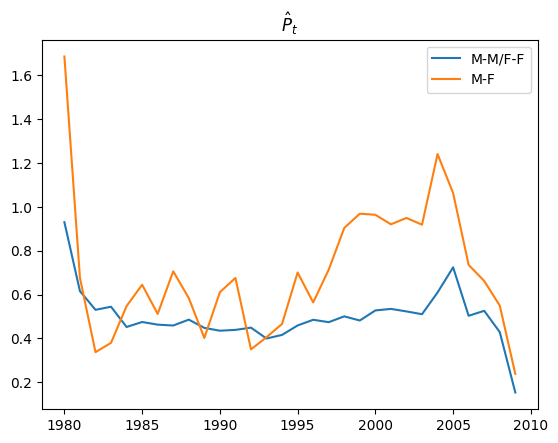

In [1774]:
#plot P parameters
p_list = {'M-M/F-F':[],'M-F':[]}
for year in range(1980,2010):
    print(year)
    p = estimate_p(G[year])
    p_list['M-M/F-F'].append(p[0,0])
    p_list['M-F'].append(p[0,1])

xdata = [i for i in range(1980,2010)]
plt.plot(xdata, p_list['M-M/F-F'])
plt.plot(xdata, p_list['M-F'])
plt.title("$\hat{P}_t$")
plt.legend(p_list.keys())

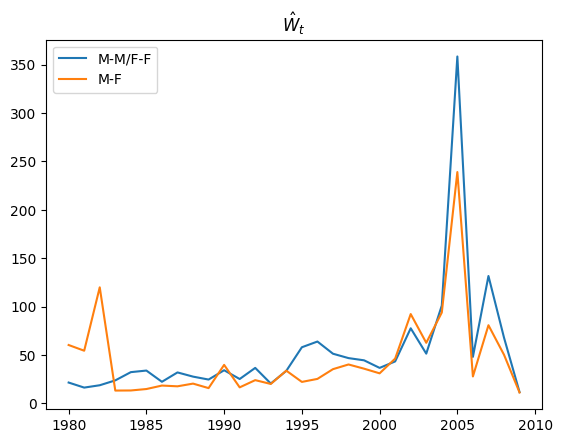

In [1775]:
#plot W parameters
w_list = {'M-M/F-F':[],'M-F':[]}
for year in range(1980,2010):
    w = estimate_w(G[year])
    w_list['M-M/F-F'].append(w[0,0])
    w_list['M-F'].append(w[0,1])

xdata = [i for i in range(1980,2010)]
plt.plot(xdata, w_list['M-M/F-F'])
plt.plot(xdata, w_list['M-F'])
plt.title("$\hat{W}_t$")
plt.legend(w_list.keys())

Text(0.5, 1.0, '$\\hat{q}_t$')

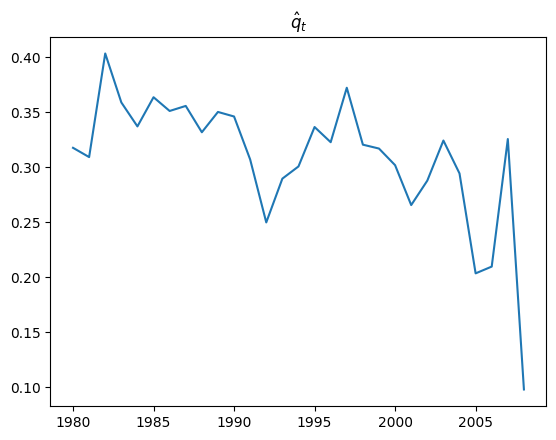

In [1776]:
#plot q parameters
q_list = []
for year in range(1980,2009):
    q = estimate_q(G,year)
    q_list.append(q)
xdata = [i for i in range(1980,2009)]
plt.plot(xdata, q_list)
plt.title('$\hat{q}_t$')

lambda: 1.1159139387626302


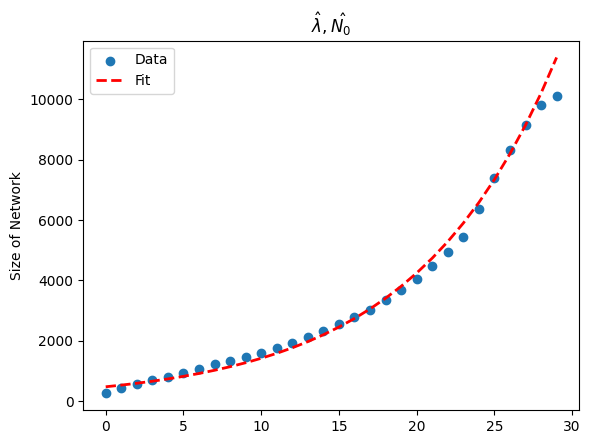

In [1777]:
lam, N0 = estimate_lambda(G)
number_of_nodes = [G[year].number_of_nodes() for year in range(1980,2010)]
plt.scatter([i for i in range(len(number_of_nodes))],np.array(number_of_nodes))
plt.plot(np.exp((np.log(lam))*np.array([i for i in range(len(number_of_nodes))]) + np.log(N0)), color='red',linestyle='--',linewidth=2)
plt.title("$\hat{\lambda}, \hat{N_0}$")
plt.ylabel("Size of Network")
print(f"lambda: {lam}")
plt.legend(['Data','Fit'])

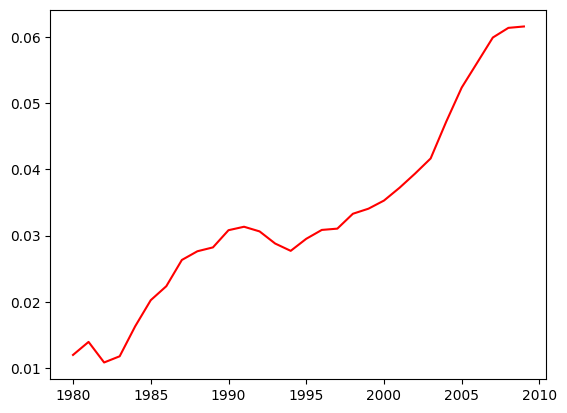

In [1778]:
perc_women = []
perc_men = []
num_women = []

xdata = [year for year in range(1980,2010)]

for year in xdata:
    G_t= G[year]
    num_gender = {0:len([n for n,v in G_t.nodes(data=True) if v['gender'] == 'M']),1: len([n for n,v in G_t.nodes(data=True) if v['gender'] == 'F'])}
    perc_women.append(num_gender[1]/G_t.number_of_nodes())
    num_women.append(num_gender[1])
    perc_men.append(num_gender[0]/G_t.number_of_nodes())

plt.plot(xdata, perc_women, 'r')
#plt.plot(xdata, perc_men, 'b')


In [1779]:
#create average parameter values
#to get aggregate measure, average across years
yearlist = [ year for year in range(1980,2009)]
average_p = sum([estimate_p(G[year]) for year in yearlist])/len([estimate_p(G[year]) for year in yearlist])
average_w = sum([estimate_w(G[year]) for year in yearlist if np.all(estimate_w(G[year])>0)])/len([estimate_w(G[year]) for year in yearlist if np.all(estimate_w(G[year])>0)])
average_q = sum([estimate_q(G,year) for year in yearlist])/ len([estimate_q(G,year) for year in yearlist])
lam, n0 = estimate_lambda(G)
T=30
print(f"p: {average_p}")
print(f"w: {average_w}")
print(f"q: {average_q}")
print(f"lambda: {lam}")
print(f"N0: {n0}")


p: [[0.51112251 0.7185212 ]
 [0.7185212  0.51112251]]
w: [[54.70817763 47.16794778]
 [47.16794778 54.70817763]]
q: 0.3086235956553056
lambda: 1.1159139387626302
N0: 473.0422270965164


In [1780]:
## Deterministic approximation from model
def deterministic_q_system(p, w, q, init_perc=0.01, N0 = 100, λ = 0.1, T=T ):
    init_perc += 1e-4
    assert init_perc < 0.5 and init_perc > 0

    n = lambda t: ((1+λ)**t)*N0
    #print(n(1))
    Phi = [init_perc]
    (a,b,alpha,beta) = (p[0,0],p[0,1],w[0,0],w[0,1])
    def memoize_Pi(p,T=T,q=q,n=n):
      Pi = np.zeros(T)
      Pi[0] = p/N0
      for t in range(1,T):
        Pi[t] = p/n(t) + q*(1-p/n(t))*Pi[t-1]
      return Pi
    Pi_a, Pi_b = memoize_Pi(a), memoize_Pi(b)
    gamma = lambda x, t: (alpha*(x**2)*Pi_a[t] + beta*x*(1-x)*Pi_b[t])/(alpha*(x**2+(1-x)**2)*Pi_a[t]+2*beta*x*(1-x)*Pi_b[t])
    for i in range(T):
      Phi.append((Phi[-1]+λ*gamma(Phi[-1],i))/(1+λ))
    #print(Phi)
    return Phi
def rho_t(p,w,q,T=T,λ = 0.1,N0 = 100,init_perc=0.01):
  n = lambda t: ((1+λ)**t)*(N0)
  (a,b,alpha,beta) = (p[0,0],p[0,1],w[0,0],w[0,1])
  def memoize_Pi(p,T=T,q=q,n=n):
      Pi = np.zeros(T)
      Pi[0] = p/N0
      for t in range(1,T):
        Pi[t] = p/n(t) + q*(1-p/n(t))*Pi[t-1]
      return Pi
  Pi_a, Pi_b = memoize_Pi(a), memoize_Pi(b)
  rhos = [(alpha*Pi_a[t])/(beta*Pi_b[t]) for t in range(T)]
  return rhos

In [1781]:
communities = {0:"Red",1:"Blue"} #communities in the graph
T = 29 #max iterations

λ,N0 = estimate_lambda(G)  #percent of existing population thats added every time step
init_perc = perc_women[0] #minority (red) initial percentage
print(λ)
q = average_w
p = average_p
w = average_w


1.1159139387626302


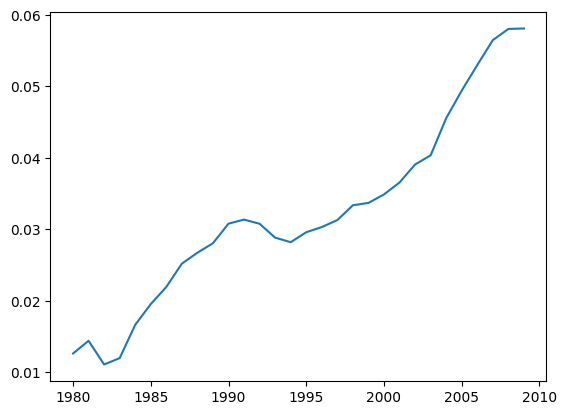

In [1783]:
perc_women_soft_restrict = []
perc_men_soft_restrict = []
num_women_soft_restrict = []

xdata = [year for year in range(1980,2010)]

for year in xdata:
    G_t= G_soft_restrict[year]
    num_gender = {0:len([n for n,v in G_t.nodes(data=True) if v['gender'] == 'M']),1: len([n for n,v in G_t.nodes(data=True) if v['gender'] == 'F'])}
    perc_women_soft_restrict.append(num_gender[1]/G_t.number_of_nodes())
    num_women_soft_restrict.append(num_gender[1])
    perc_men_soft_restrict.append(num_gender[0]/G_t.number_of_nodes())

plt.plot(xdata,perc_women_soft_restrict)

In [1784]:
#parameters for model with soft restriction (from paper Appendexi)
P_soft = np.array([[0.35850097,0.46849],[0.46849,0.35850097]])
W_soft = np.array([[14.337, 18.026],[18.026,14.337]])
q_soft = 0.265
lam_soft = 0.1147
N0_soft = 466.2
init_perc_soft = perc_women_soft_restrict[0]

30
30
30


(0.0, 0.1)

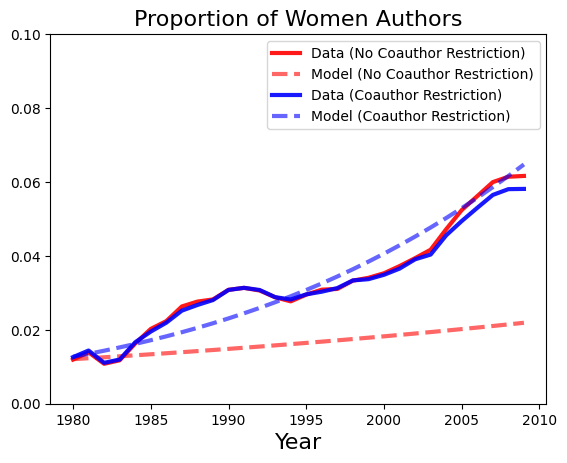

In [1792]:
yearlist = [ year for year in range(1980,2010)]
print(len(yearlist))

Phi = deterministic_q_system(average_p,average_w,average_q, λ=λ-1,N0=N0,init_perc=init_perc,T=T)
Phi2 = deterministic_q_system(average_p,average_w,0, λ=λ-1,N0=N0,init_perc=init_perc,T=T) #baseline model (q=0)
Phi_soft = deterministic_q_system(P_soft,W_soft,q_soft, λ=lam_soft,N0=N0_soft,init_perc=init_perc_soft,T=T)
Phi_soft2 = deterministic_q_system(P_soft,W_soft,0, λ=lam_soft,N0=N0_soft,init_perc=init_perc_soft,T=T) #baseline model (q=0)


print(len(Phi))
print(len(perc_women))
plt.plot(yearlist, perc_women, color='r',linewidth=3, alpha=0.9)
plt.plot(yearlist, Phi, color='r', linestyle="--", linewidth=3, alpha=0.6)
#plt.plot(yearlist,Phi2,linestyle=':', linewidth=3,alpha=0.4)
plt.plot(yearlist, perc_women_soft_restrict,color='blue',linewidth=3, alpha=0.9)
plt.plot(yearlist, Phi_soft, linestyle="--", color='blue',linewidth=3, alpha=0.6)
#plt.plot(yearlist,Phi_soft2,linestyle=':', linewidth=3,alpha=0.4)

plt.title("Proportion of Women Authors", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.legend(["Data (No Coauthor Restriction)","Model (No Coauthor Restriction)", "Data (Coauthor Restriction)", "Model (Coauthor Restriction)"])
plt.ylim((0,0.1))

(0.0, 0.07)

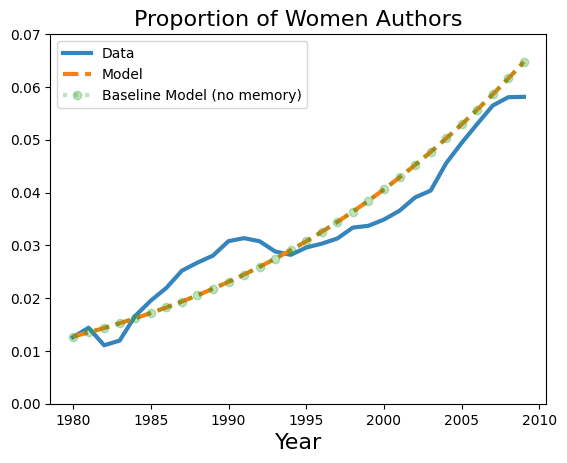

In [1811]:
yearlist = [ year for year in range(1980,2010)]
Phi_soft = deterministic_q_system(P_soft,W_soft,q_soft, λ=lam_soft,N0=N0_soft,init_perc=init_perc_soft,T=T)
Phi_soft2 = deterministic_q_system(P_soft,W_soft,0, λ=lam_soft,N0=N0_soft,init_perc=init_perc_soft,T=T) #baseline model (q=0)
plt.plot(yearlist, perc_women_soft_restrict,linewidth=3, alpha=0.9)
plt.plot(yearlist, Phi_soft, linestyle="--",linewidth=3, alpha=1)
plt.plot(yearlist, Phi_soft, "o:",linewidth=3, alpha=0.3)

plt.title("Proportion of Women Authors", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.legend(["Data","Model", "Baseline Model (no memory)"])

plt.ylim(0,0.07)